In [1]:
import csv
from scipy import linalg as la
from scipy.optimize import linprog
import numpy as np
import cvxpy as cp

In [2]:
import matplotlib.pyplot as plt

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Synthetic Example 1: Fixed System

In [3]:
T = 52
d = 2

alpha = 0.4
u = np.zeros((T, d))
x = np.zeros((T, d))
J = np.zeros((T, ))
u2 = np.zeros((T, d))
x2 = np.zeros((T, d))
J2 = np.zeros((T, ))

x0 = np.array([1, 1])
mean = [0, 0]

W = 0.01*np.eye(2)
x[0, :] = x0
x2[0, :] = x0

Z = np.matrix([[0, 0], [0, 0]])
K = []

Q = np.matrix([[0.2, 0], [0, 0.2]])
R = np.matrix([[1, 0], [0, 1]])

x_list = []
J_list = []

x_list2 = []
J_list2 = []

np.random.seed(6)
Alist = []
for t in range(T):
    A = np.matrix([[0.99, 1.5], [0, 0.99]])
    Alist.append(A)

    
for n in range(5): 
    print(n)
    np.random.seed(n)    
    
    for t in range(T-1):
        A = Alist[t]
        #A = np.matrix([[0.95, 2*np.random.randn()+1], [2*np.random.randn()+1, 0.95]])
        B = np.matrix([[1, 0], [0, 1]])

        S11 = cp.Variable((d, d), PSD=True)
        S12 = cp.Variable((d, d))
        S22 = cp.Variable((d, d), PSD=True)

        # The operator >> denotes matrix inequality.
        constraints = [cp.bmat([[A, B]])@cp.bmat([[S11, S12], [S12.T, S22]])@cp.bmat([[A, B]]).T+W==S11]
        constraints += [cp.bmat([[S11, S12], [S12.T, S22]]) >> 0]
        constraints += [cp.bmat([[A, B]])@cp.bmat([[S11, S12], [S12.T, S22]])@cp.bmat([[A, B]]).T << alpha*S11]

        prob = cp.Problem(cp.Minimize(cp.trace(cp.bmat([[Q, Z], [Z, R]]).T@(cp.bmat([[S11, S12], [S12.T, S22]])))),
                          constraints)

        prob.solve()

        x_t = x[t, :].reshape((2,1))
        K_t = S12.T.value@la.inv(S11.value)
        u_t = K_t@x_t
        w_t = np.random.multivariate_normal(mean, W, 1)
        J_t = (x_t.T@Q@x_t+u_t.T@R@u_t)

        x_next = A@x_t+B@u_t+w_t.reshape((2,1))                                                                       
        u[t, :] = u_t.T
        x[t+1, :] = x_next.T                                                                

        if(t==0):
            J[t,] = J_t
        else:
            J[t,] = J_t+J[t-1,]


        P_t = la.solve_discrete_are(A, B, Q, R)
        K_t = -np.linalg.inv(R+B.T@P_t@B)*B.T@P_t@A 

        x_t = x2[t, :].reshape((2,1))
        u_t = K_t@x_t
        #w_t = np.random.multivariate_normal(mean, W, 1)
        J_t2 = (x_t.T@Q@x_t+u_t.T@R@u_t)

        x_next = A@x_t+B@u_t+w_t.reshape((2,1))                                                                       
        u2[t, :] = u_t.T
        x2[t+1, :] = x_next.T                                                                

        if(t==0):
            J2[t,] = J_t2
        else:
            J2[t,] = J_t2+J2[t-1,]  
    
    x_list.append(la.norm(x, axis=1))
    J_list.append(J)
    x_list2.append(la.norm(x2, axis=1))
    J_list2.append(J2)

0
1
2
3
4


<ipython-input-4-14a01a6fa5ba>:12: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50] in fill_betweenx(). This will become an error two minor releases later.
  plt.fill_between(x, x2_mean-x2_var, x2_mean+x2_var, 'b', alpha=0.2)
<ipython-input-4-14a01a6fa5ba>:13: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50] in fill_betweenx(). This will become an error two minor releases later.
  plt.fill_between(x, x1_mean-x1_var, x1_mean+x1_var, 'r', alpha=0.2)


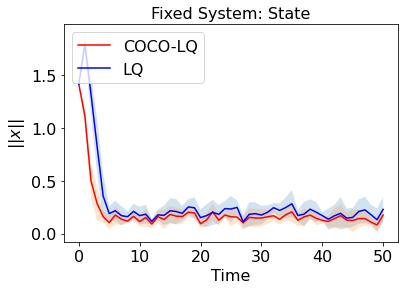

<Figure size 432x288 with 0 Axes>

In [4]:
T= 51
x1_mean = np.average(x_list, axis = 0)[0:T]
x1_var = np.std(x_list, axis = 0)[0:T]

x2_mean = np.average(x_list2, axis = 0)[0:T]
x2_var = np.std(x_list2, axis = 0)[0:T]

x = np.arange(0, T)

plt.plot()
plt.plot(x, x1_mean, 'r', label = 'COCO-LQ')
plt.fill_between(x, x2_mean-x2_var, x2_mean+x2_var, 'b', alpha=0.2)
plt.fill_between(x, x1_mean-x1_var, x1_mean+x1_var, 'r', alpha=0.2)
plt.plot(x, x2_mean, 'b', label = 'LQ')

plt.legend(loc ='upper left')
plt.xlabel('Time')
plt.ylabel('$||x||$')
plt.title('Fixed System: State')
plt.show()
plt.savefig('syn_fixed_state.png')

### Synthetic Example 2: Switching Linear System

In [5]:
# coco-LQ
T = 101
d = 2

alpha = 0.4
u = np.zeros((T, d))
x = np.zeros((T, d))
J = np.zeros((T, ))
u2 = np.zeros((T, d))
x2 = np.zeros((T, d))
J2 = np.zeros((T, ))

x0 = np.array([1, 1])
mean = [0, 0]

W = 0.01*np.eye(2)
x[0, :] = x0
x2[0, :] = x0

Z = np.matrix([[0, 0], [0, 0]])
K = []

Q = np.matrix([[0.2, 0], [0, 0.2]])
R = np.matrix([[1, 0], [0, 1]])

x_list = []
J_list = []

x_list2 = []
J_list2 = []

for n in range(5): 
    print(n)
    np.random.seed(n)
    for t in range(T-1):
        if(t%2==0):
            A = np.matrix([[0.99, 1.5], [0, 0.99]])
            B = np.matrix([[1, 0], [0, 1]])
        else:
            A = np.matrix([[0.99, 0], [1.5, 0.99]])
            B = np.matrix([[1, 0], [0, 1]])      

        S11 = cp.Variable((d, d), PSD=True)
        S12 = cp.Variable((d, d))
        S22 = cp.Variable((d, d), PSD=True)

        # The operator >> denotes matrix inequality.
        constraints = [cp.bmat([[A, B]])@cp.bmat([[S11, S12], [S12.T, S22]])@cp.bmat([[A, B]]).T+W==S11]
        constraints += [cp.bmat([[S11, S12], [S12.T, S22]]) >> 0]
        constraints += [cp.bmat([[A, B]])@cp.bmat([[S11, S12], [S12.T, S22]])@cp.bmat([[A, B]]).T << alpha*S11]

        prob = cp.Problem(cp.Minimize(cp.trace(cp.bmat([[Q, Z], [Z, R]]).T@(cp.bmat([[S11, S12], [S12.T, S22]])))),
                          constraints)
        prob.solve()

        x_t = x[t, :].reshape((2,1))
        K_t = S12.T.value@la.inv(S11.value)
        u_t = K_t@x_t
        w_t = np.random.multivariate_normal(mean, W, 1)
        J_t = (x_t.T@Q@x_t+u_t.T@R@u_t)

        x_next = A@x_t+B@u_t+w_t.reshape((2,1))                                                                       
        u[t, :] = u_t.T
        x[t+1, :] = x_next.T                                                                

        if(t==0):
            J[t,] = J_t
        else:
            J[t,] = J_t+J[t-1,]
    
        #LQR
        P_t = la.solve_discrete_are(A, B, Q, R)
        K_t = -np.linalg.inv(R+B.T@P_t@B)*B.T@P_t@A 
        x_t = x2[t, :].reshape((2,1))
        u_t = K_t@x_t
        #w_t = np.random.multivariate_normal(mean, W, 1)
        J_t = (x_t.T@Q@x_t+u_t.T@R@u_t)

        x_next = A@x_t+B@u_t+w_t.reshape((2,1))                                                                       
        u2[t, :] = u_t.T
        x2[t+1, :] = x_next.T                                                                

        if(t==0):
            J2[t,] = J_t
        else:
            J2[t,] = J_t+J2[t-1,]
    
    x_list.append(la.norm(x, axis=1))
    J_list.append(J)
    x_list2.append(la.norm(x2, axis=1))
    J_list2.append(J2)

0
1
2
3
4


<ipython-input-6-4081b10e68b5>:14: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50] in fill_betweenx(). This will become an error two minor releases later.
  plt.fill_between(x, x2_mean-x2_var, x2_mean+x2_var, 'b', alpha=0.2)


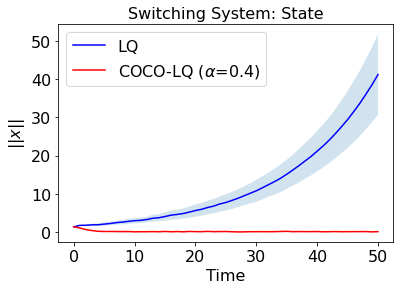

In [6]:
T= 51
x1_mean = np.average(x_list, axis = 0)[0:T]
x1_var = np.std(x_list, axis = 0)[0:T]

x2_mean = np.average(x_list2, axis = 0)[0:T]
x2_var = np.std(x_list2, axis = 0)[0:T]

x = np.arange(0, T)

plt.plot()
plt.plot(x, x2_mean, 'b', label = 'LQ')
plt.plot(x, x1_mean, 'r', label = r'COCO-LQ ($\alpha$=0.4)')
#plt.fill_between(x, x1_mean-x1_var, x1_mean+x1_var, 'r', alpha=0.3)
plt.fill_between(x, x2_mean-x2_var, x2_mean+x2_var, 'b', alpha=0.2)
plt.legend(loc ='upper left')
plt.xlabel('Time')
plt.ylabel('$||x||$')
plt.title('Switching System: State')
#plt.show()
plt.savefig('syn_switching_state.png')

### Synthetic Example 3: Time-variant System

In [7]:
T = 52
d = 2

alpha = 0.4
u = np.zeros((T, d))
x = np.zeros((T, d))
J = np.zeros((T, ))
u2 = np.zeros((T, d))
x2 = np.zeros((T, d))
J2 = np.zeros((T, ))

x0 = np.array([1, 1])
mean = [0, 0]

W = 0.01*np.eye(2)
x[0, :] = x0
x2[0, :] = x0

Z = np.matrix([[0, 0], [0, 0]])
K = []

Q = np.matrix([[0.2, 0], [0, 0.2]])
R = np.matrix([[1, 0], [0, 1]])

x_list = []
J_list = []

x_list2 = []
J_list2 = []

np.random.seed(6)
Alist = []
for t in range(T):
    A = np.matrix([[0.99, 1.5], [0, 0.99]])
    A[0,1] = np.abs(np.sin(np.pi*t/2))*np.exp(t/60)
    A[1,0] = np.abs(np.cos(np.pi*t/2))*np.exp(t/60)
    Alist.append(A)

    
for n in range(5): 
    print(n)
    np.random.seed(n)    
    
    for t in range(T-1):
        A = Alist[t]
        #A = np.matrix([[0.95, 2*np.random.randn()+1], [2*np.random.randn()+1, 0.95]])
        B = np.matrix([[1, 0], [0, 1]])

        S11 = cp.Variable((d, d), PSD=True)
        S12 = cp.Variable((d, d))
        S22 = cp.Variable((d, d), PSD=True)

        X0 = (la.norm(x[t, :],2))**2
        # The operator >> denotes matrix inequality.
        constraints = [cp.bmat([[A, B]])@cp.bmat([[S11, S12], [S12.T, S22]])@cp.bmat([[A, B]]).T+W==S11]
        constraints += [cp.bmat([[S11, S12], [S12.T, S22]]) >> 0]
        constraints += [cp.bmat([[A, B]])@cp.bmat([[S11, S12], [S12.T, S22]])@cp.bmat([[A, B]]).T << alpha*S11]

        prob = cp.Problem(cp.Minimize(cp.trace(cp.bmat([[Q, Z], [Z, R]]).T@(cp.bmat([[S11, S12], [S12.T, S22]])))),
                          constraints)
        prob.solve()

        x_t = x[t, :].reshape((2,1))
        K_t = S12.T.value@la.inv(S11.value)
        u_t = K_t@x_t
        w_t = np.random.multivariate_normal(mean, W, 1)
        J_t = (x_t.T@Q@x_t+u_t.T@R@u_t)

        x_next = A@x_t+B@u_t+w_t.reshape((2,1))                                                                       
        u[t, :] = u_t.T
        x[t+1, :] = x_next.T                                                                

        if(t==0):
            J[t,] = J_t
        else:
            J[t,] = J_t+J[t-1,]

        P_t = la.solve_discrete_are(A, B, Q, R)
        K_t = -np.linalg.inv(R+B.T@P_t@B)*B.T@P_t@A 
        
        x_t = x2[t, :].reshape((2,1))
        u_t = K_t@x_t
        #w_t = np.random.multivariate_normal(mean, W, 1)
        J_t2 = (x_t.T@Q@x_t+u_t.T@R@u_t)

        x_next = A@x_t+B@u_t+w_t.reshape((2,1))                                                                       
        u2[t, :] = u_t.T
        x2[t+1, :] = x_next.T                                                                

        if(t==0):
            J2[t,] = J_t2
        else:
            J2[t,] = J_t2+J2[t-1,]  
    
    x_list.append(la.norm(x, axis=1))
    J_list.append(J)
    x_list2.append(la.norm(x2, axis=1))
    J_list2.append(J2)

0
1
2
3
4


<ipython-input-8-ef6840e78407>:12: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50] in fill_betweenx(). This will become an error two minor releases later.
  plt.fill_between(x, x2_mean-x2_var, x2_mean+x2_var, 'b', alpha=0.2)
<ipython-input-8-ef6840e78407>:14: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50] in fill_betweenx(). This will become an error two minor releases later.
  plt.fill_between(x, x1_mean-x1_var, x1_mean+x1_var, 'r', alpha=0.2)


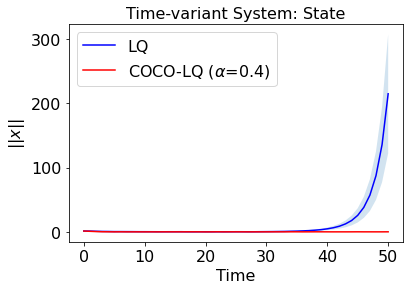

<Figure size 432x288 with 0 Axes>

In [8]:
T= 51
x1_mean = np.average(x_list, axis = 0)[0:T]
x1_var = np.std(x_list, axis = 0)[0:T]

x2_mean = np.average(x_list2, axis = 0)[0:T]
x2_var = np.std(x_list2, axis = 0)[0:T]

x = np.arange(0, T)

plt.plot()
plt.plot(x, x2_mean, 'b', label = 'LQ')
plt.fill_between(x, x2_mean-x2_var, x2_mean+x2_var, 'b', alpha=0.2)
plt.plot(x, x1_mean, 'r', label = r'COCO-LQ ($\alpha$=0.4)')
plt.fill_between(x, x1_mean-x1_var, x1_mean+x1_var, 'r', alpha=0.2)


plt.legend(loc ='upper left')
plt.xlabel('Time')
plt.ylabel('$||x||$')
plt.title('Time-variant System: State')
plt.show()
plt.savefig('syn_variant_state.png')

### Plot the effect of $\alpha$

In [14]:
def ltv_solver(A_list, B, Q, R, x0, w_mean, w_cov, alpha, T, seed):
    np.random.seed(seed)
    #state dimension
    d = A_list[0].shape[0]
    #state sequence
    x = np.zeros((T, d))
    #control sequence
    u = np.zeros((T, d))
    #cost sequence
    J = np.zeros((T, ))

    x[0, :] = x0
    Z = np.matrix([[0, 0], [0, 0]])  
    
    for t in range(T-1):
        A = A_list[t]
        #A = np.random.randn(2,2)
    
        #Solve SDP to get the control input 
        S11 = cp.Variable((d, d), symmetric=True)
        S12 = cp.Variable((d, d))
        S22 = cp.Variable((d, d), symmetric=True)

        # The operator >> denotes matrix inequality.
        constraints = [cp.bmat([[A, B]])@cp.bmat([[S11, S12], [S12.T, S22]])@cp.bmat([[A, B]]).T+w_cov==S11]
        constraints += [cp.bmat([[S11, S12], [S12.T, S22]]) >> 0]
        constraints += [cp.bmat([[A, B]])@cp.bmat([[S11, S12], [S12.T, S22]])@cp.bmat([[A, B]]).T << alpha*S11]

        prob = cp.Problem(cp.Minimize(cp.trace(cp.bmat([[Q, Z], [Z, R]]).T@(cp.bmat([[S11, S12], [S12.T, S22]])))),
                          constraints)
        prob.solve()

        x_t = x[t, :].reshape((2,1))
        K_t = S12.T.value@la.inv(S11.value)
        u_t = K_t@x_t
        w_t = np.random.multivariate_normal(w_mean, w_cov, 1)
        J_t = (x_t.T@Q@x_t+u_t.T@R@u_t)

        x_next = A@x_t+B@u_t+w_t.reshape((2,1))                                                                       
        u[t, :] = u_t.T
        x[t+1, :] = x_next.T                                                                

        if(t==0):
            J[t,] = J_t
        else:
            J[t,] = J_t+J[t-1,]
    return x, u, J

In [15]:
def lqr_solver(A_list, B, Q, R, x0, w_mean, w_cov, alpha, T, seed):
    np.random.seed(seed)
    #state dimension
    d = A_list[0].shape[0]
    #state sequence
    x = np.zeros((T, d))
    #control sequence
    u = np.zeros((T, d))
    #cost sequence
    J = np.zeros((T, ))

    x[0, :] = x0
    Z = np.matrix([[0, 0], [0, 0]])

    for t in range(T-1):
        A = A_list[t]
        #A = np.random.randn(2,2)
    
        #Solve Reccati equation 
        P_t = la.solve_discrete_are(A, B, Q, R)
        
        x_t = x[t, :].reshape((2,1))
        K_t = -np.linalg.inv(R+B.T@P_t@B)*B.T@P_t@A 
        u_t = K_t@x_t
        w_t = np.random.multivariate_normal(w_mean, w_cov, 1)
        J_t = (x_t.T@Q@x_t+u_t.T@R@u_t)

        x_next = A@x_t+B@u_t+w_t.reshape((2,1))                                                                       
        u[t, :] = u_t.T
        x[t+1, :] = x_next.T                                                                

        if(t==0):
            J[t,] = J_t
        else:
            J[t,] = J_t+J[t-1,]
    return x, u, J

In [16]:
np.random.seed(2)
option = 'switching'
T = 100

Alist = []
if(option=='fixed'):
    for t in range(T):
        A = np.matrix([[0.99, 1.5], [0, 0.99]])
        Alist.append(A)
elif(option=='switching'):
    for t in range(T):
        if(t%2==0):
            A = np.matrix([[0.99, 1.5], [0, 0.99]])
        else:
            A = np.matrix([[0.99, 0], [1.5, 0.99]])
        Alist.append(A)
else:
    for t in range(T):
        A = np.matrix([[0.99, 1.5], [0, 0.99]])
        A[0,1] = np.abs(np.sin(np.pi*t/2))*np.exp(t/60)
        A[1,0] = np.abs(np.cos(np.pi*t/2))*np.exp(t/60)
        Alist.append(A)

B = np.matrix([[1, 0], [0, 1]])
Q = np.matrix([[0.2, 0], [0, 0.2]])
R = np.matrix([[1, 0], [0, 1]])
x0 = np.array([1, 1])

w_mean = np.array([0, 0])
w_cov = 0.01*np.eye(2)

Lx_mean = []
Lx_var = []
LJ_mean = []
LJ_var = []
for i in range(11):
    print('Current i', i)
    alpha = 0.1*i
    
    x_list = []
    J_list = []
    for n in range(5):
        x, u, J = ltv_solver(Alist, B, Q, R, x0, w_mean, w_cov, alpha, T, n)
        x_list.append(la.norm(x, axis=1))
        J_list.append(J)
    
    x_mean = np.average(x_list, axis = 0)
    x_var = np.std(x_list, axis = 0)
    J_mean = np.average(J_list, axis = 0)
    J_var = np.std(J_list, axis = 0)

    Lx_mean.append(x_mean)
    Lx_var.append(x_var)
    LJ_mean.append(J_mean)
    LJ_var.append(J_var)

Current i 0
Current i 1
Current i 2
Current i 3
Current i 4
Current i 5
Current i 6
Current i 7
Current i 8
Current i 9
Current i 10


## Offline optimal

In [21]:
np.random.seed(2)
option = 'switching'
T = 100
d = 2
Alist = []
if(option=='fixed'):
    for t in range(T):
        A = np.matrix([[0.99, 1.5], [0, 0.99]])
        Alist.append(A)
elif(option=='switching'):
    for t in range(T):
        if(t%2==0):
            A = np.matrix([[0.99, 1.5], [0, 0.99]])
        else:
            A = np.matrix([[0.99, 0], [1.5, 0.99]])
        Alist.append(A)
else:
    for t in range(T):
        A = np.matrix([[0.99, 1.5], [0, 0.99]])
        A[0,1] = np.abs(np.sin(np.pi*t/2))*np.exp(t/60)
        A[1,0] = np.abs(np.cos(np.pi*t/2))*np.exp(t/60)
        Alist.append(A)

P_list = []
for t in range(T-1, -1, -1):
    if(t==T-1):
        P = Q
        P_list.append(P)
    else:
        P = Alist[t].T@P_list[T-2-t]@Alist[t]+Q-Alist[t].T@P_list[T-2-t]@B@np.linalg.inv(R+B.T@P_list[T-2-t]@B)@B.T@P_list[T-2-t]@Alist[t]
        P_list.append(P)
        
P_list.reverse()

K_list = []
x_opt = np.zeros((T, d))
#control sequence
u_opt = np.zeros((T, d))
#cost sequence
J_opt = np.zeros((T, ))

x_opt[0, :] = np.array([1, 1])
for t in range(T-1):
    x_optt = x_opt[t, :].reshape((2,1))
    K_optt = np.linalg.inv(R+B.T@P_list[t+1]@B)*B.T@P_list[t+1]@Alist[t]
    K_list.append(K_optt)
    
    u_optt = -K_optt@x_optt
    w_t = np.random.multivariate_normal(w_mean, w_cov, 1)
    J_optt = (x_optt.T@Q@x_optt+u_optt.T@R@u_optt)

    x_next = Alist[t]@x_optt+B@u_optt+w_t.reshape((2,1))                                                                       
    u_opt[t, :] = u_optt.T
    x_opt[t+1, :] = x_next.T                                                                

    if(t==0):
        J_opt[t,] = J_optt
    else:
        J_opt[t,] = J_optt+J_opt[t-1,]

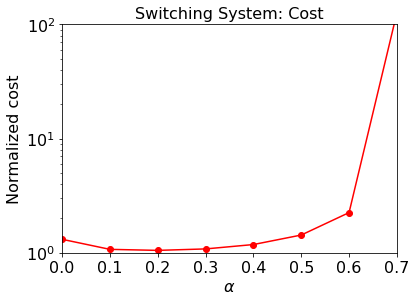

In [22]:
T = 100
Lcost_mean = []
Lcost_var = []
Lalpha = []

for i in range(0, 11):
    alpha = i*0.1;
    cost_mean = LJ_mean[i][-2]/J_opt[-2]
    cost_var = LJ_var[i][-2]/(T-1)
    Lalpha.append(alpha)
    Lcost_mean.append(cost_mean)
    Lcost_var.append(cost_var)

Lcost_var = np.array(Lcost_var)
Lcost_mean = np.array(Lcost_mean)

plt.figure(figsize=(6,4.2))
plt.plot(Lalpha, Lcost_mean, 'r-')
plt.errorbar(Lalpha, Lcost_mean, fmt='ro', ecolor='r', capthick=1)
#plt.axhline(y=1, color='k', linestyle='--')
plt.xlim([0, 0.7])
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
plt.ylim([1, 1e2])
plt.title('Switching System: Cost')
plt.ylabel('Normalized cost')
plt.xlabel(r'$\alpha$')
plt.yscale('log')
#plt.savefig('alpha_cost_variant.png')

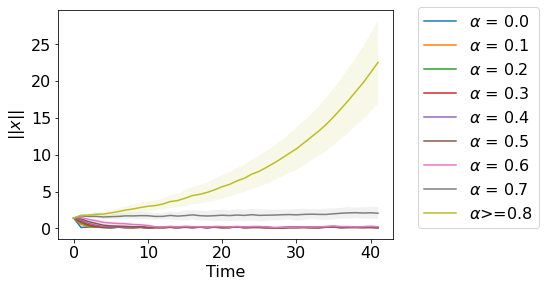

In [23]:
T = 42
x = np.arange(0, T)
plt.figure(figsize=(6,4.2))
for i in range(0, 9):
    if(i<8):
        plt.plot(x, Lx_mean[i][0:T], label = r'$\alpha$ = %.1f'%(0.1*i))
        plt.fill_between(x, Lx_mean[i][0:T]-Lx_var[i][0:T], Lx_mean[i][0:T]+Lx_var[i][0:T], alpha=0.1)
    else:
        plt.plot(x, Lx_mean[i][0:T], label = r'$\alpha$>=0.8')
        plt.fill_between(x, Lx_mean[i][0:T]-Lx_var[i][0:T], Lx_mean[i][0:T]+Lx_var[i][0:T], alpha=0.1)
        
#plt.legend(loc = 'upper left')
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.ylabel('$||x||$')
plt.xlabel('Time')
plt.savefig('alpha_stability_variant.png')